In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shap
import optuna
import pickle

from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [158]:
PATH = '/kaggle/input/cmc-ml-spotify-tracks-popularity-prediction-2025/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cmc-ml-spotify-tracks-popularity-prediction-2025/sample_submission.csv
/kaggle/input/cmc-ml-spotify-tracks-popularity-prediction-2025/simple_pipeline.ipynb
/kaggle/input/cmc-ml-spotify-tracks-popularity-prediction-2025/train.csv
/kaggle/input/cmc-ml-spotify-tracks-popularity-prediction-2025/test.csv


In [266]:
train = pd.read_csv(PATH + "train.csv") 
test = pd.read_csv(PATH + "test.csv")

X_test = test.drop("index", axis=1) 
X_train = train.drop(["index", "popularity"], axis=1) 
y_train = train["popularity"]

In [160]:
train.head()

,index,composer,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
0,113287,14,1412,2967.280,0.045235,1,-38.440550,1,0.036275,-0.223432,0.706,474.7080,0.093009,95.49426,1113008.40,4,2
1,49396,7,9772,5596.904,0.071796,9,-43.769375,1,0.050086,-0.212998,0.777,511.9400,0.609760,114.64017,116020.83,3,2
2,122241,16,10251,3345.864,0.109368,4,-42.194985,0,0.037856,-0.212332,0.925,497.9780,0.112270,101.37465,348964.32,3,0
3,123302,16,9342,2486.376,0.056395,9,-33.632870,0,0.032282,-0.212554,0.906,334.1572,0.079207,128.98356,382820.43,4,0
4,72027,9,4646,6169.896,0.086304,2,-33.402815,1,0.034611,-0.235420,0.932,465.4000,0.386250,106.71843,221056.80,3,11


In [161]:
test.head()

,index,composer,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,1,3217,2701.248,0.100440,4,-30.061540,0,0.030202,-0.278932,0.91900,539.8640,0.113300,116.47227,830713.20,4
1,1,11,8739,1995.240,0.096720,3,-32.346440,1,0.036858,-0.219880,0.00169,2666.7420,0.038625,84.60861,300932.40,3
2,2,2,2548,4727.184,0.003586,1,-46.639585,0,0.041184,-0.211888,0.89100,387.6782,0.052427,102.35487,340167.57,4
3,3,1,3219,2445.448,0.122760,5,-27.883060,1,0.029370,-0.223432,0.91200,388.1436,0.071276,133.82328,838408.83,4
4,4,0,11933,4942.056,0.116064,9,-32.474770,0,0.033030,-0.214774,0.62400,474.7080,0.378010,123.41565,246248.25,3


In [162]:
print(len(train))
print(len(test))

print(len(X_train))
print(len(X_test))

70000
69524
70000
69524


# EDA

In [163]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             70000 non-null  int64  
 1   composer          70000 non-null  int64  
 2   album             70000 non-null  int64  
 3   danceability      70000 non-null  float64
 4   energy            70000 non-null  float64
 5   key               70000 non-null  int64  
 6   loudness          70000 non-null  float64
 7   mode              70000 non-null  int64  
 8   speechiness       70000 non-null  float64
 9   acousticness      70000 non-null  float64
 10  instrumentalness  70000 non-null  float64
 11  liveness          70000 non-null  float64
 12  valence           70000 non-null  float64
 13  tempo             70000 non-null  float64
 14  duration_ms       70000 non-null  float64
 15  time_signature    70000 non-null  int64  
 16  popularity        70000 non-null  int64 

In [164]:
train.describe()

,index,composer,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,7.000000e+04,70000.000000,70000.000000
mean,69864.997643,8.947443,6296.756657,3460.869327,0.095826,5.162014,-38.038053,0.693214,0.044565,-0.223222,0.534360,738.630144,0.284937,96.688282,3.056679e+05,3.656857,2.690114
std,40216.400679,5.561778,3844.204745,1332.473130,0.083451,3.439068,8.908675,0.461163,0.048168,0.019497,0.398336,589.127513,0.246829,27.975046,2.120986e+05,0.756819,5.166749
min,0.000000,0.000000,0.000000,0.000000,0.000100,0.000000,-88.774080,0.000000,0.000000,-0.432312,0.000000,0.000000,0.000000,0.000000,1.875597e+04,0.000000,0.000000
25%,35116.750000,5.000000,2980.000000,2496.608000,0.031025,2.000000,-43.354650,0.000000,0.032032,-0.224764,0.018700,427.702600,0.082400,73.941510,1.631148e+05,3.000000,0.000000
50%,69972.000000,9.000000,6039.000000,3417.488000,0.075144,5.000000,-37.038310,1.000000,0.036026,-0.216550,0.759000,530.556000,0.199820,92.230890,2.506244e+05,4.000000,1.000000
75%,104530.250000,13.000000,9600.000000,4348.600000,0.138384,8.000000,-31.767390,1.000000,0.042099,-0.213220,0.897000,777.218000,0.421270,117.299273,3.862059e+05,4.000000,3.000000
max,139521.000000,18.000000,12805.000000,8901.840000,0.743256,11.000000,-10.848035,1.000000,0.801216,-0.211888,0.999000,4565.574000,1.026910,221.475780,2.539388e+06,5.000000,77.000000


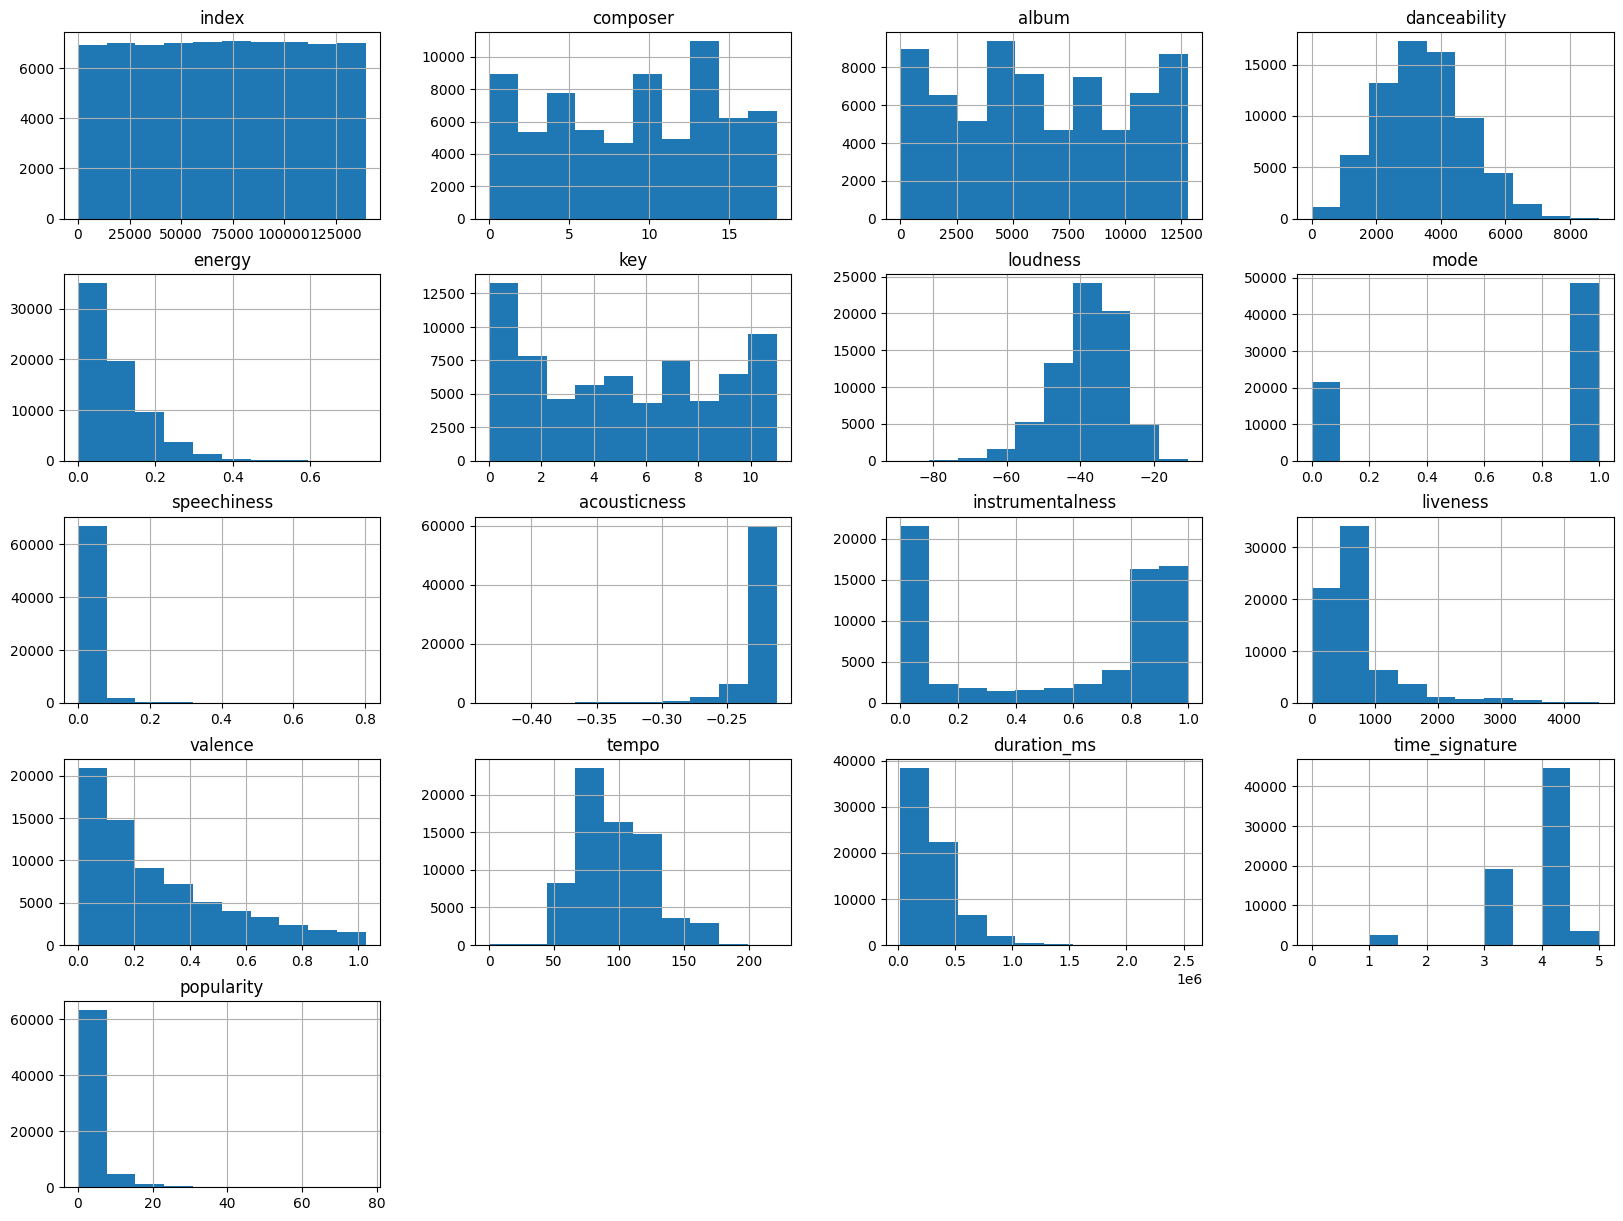

In [165]:
train.hist(figsize=(20, 15))
plt.show()

In [166]:
for col in X_train.columns:
    print(f"{col}: {X_train[col].nunique()} уникальных значений")

composer: 19 уникальных значений
album: 11837 уникальных значений
danceability: 1108 уникальных значений
energy: 2530 уникальных значений
key: 12 уникальных значений
loudness: 21904 уникальных значений
mode: 2 уникальных значений
speechiness: 1323 уникальных значений
acousticness: 815 уникальных значений
instrumentalness: 5042 уникальных значений
liveness: 1510 уникальных значений
valence: 1630 уникальных значений
tempo: 49052 уникальных значений
duration_ms: 37101 уникальных значений
time_signature: 5 уникальных значений


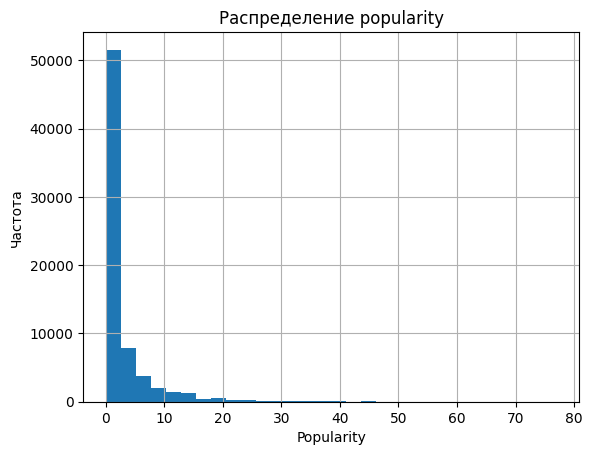

In [167]:
y_train.hist(bins=30)
plt.xlabel('Popularity')
plt.ylabel('Частота')
plt.title('Распределение popularity')
plt.show()

In [168]:
print(y_train.value_counts().sort_index())

popularity
0     25246
1     18153
2      8151
3      4760
4      3161
6      2176
7      1598
8      1155
9       888
11      772
12      609
13      473
14      440
15      368
17      326
18      219
19      204
20      180
22      120
23      133
24       98
25       83
27       77
28       65
29       67
30       64
31       42
33       38
34       30
35       30
36       30
38       34
39       25
40       18
41       19
43       21
44       17
45       15
46       11
47        9
49        9
50        7
51        6
52        6
54        9
55        6
56        4
57        1
59        4
60        4
61        2
62        3
63        2
65        3
66        1
67        2
71        1
72        3
76        1
77        1
Name: count, dtype: int64


In [169]:
print("Статистика popularity:")
print(train['popularity'].describe())
print("\nКвантили popularity:")
print(train['popularity'].quantile([0, 0.25, 0.5, 0.75, 1]))

Статистика popularity:
count    70000.000000
mean         2.690114
std          5.166749
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         77.000000
Name: popularity, dtype: float64

Квантили popularity:
0.00     0.0
0.25     0.0
0.50     1.0
0.75     3.0
1.00    77.0
Name: popularity, dtype: float64


Большинство треков имеют низкую популярность, а высокопопулярных очень мало  
Популярность - дискретная переменная с большим числом нулевых и малых значений  
Распределение похоже на экспоненциальное только в основной массе малых значений  
В кросс-валидации обязательно надо будет стратифицировать по квантилям, чтобы учесть редкие "хвостовые" значения  

In [170]:
composer_counts = train['composer'].value_counts()
print("Количество треков на композитора:")
print(composer_counts)

Количество треков на композитора:
composer
9     8131
13    7686
0     6721
18    5766
5     4940
16    4799
8     4643
2     3494
14    3287
7     3259
12    3157
4     2840
1     2246
6     2239
3     1853
11    1784
15    1447
17     871
10     837
Name: count, dtype: int64


In [171]:
album_counts = train['album'].value_counts()
print("Количество треков на альбом (топ 20):")
print(album_counts.head(20))

Количество треков на альбом (топ 20):
album
5697     204
5696     121
5095     118
11188    103
7916      99
491       97
11336     97
12419     96
11970     93
11189     92
11251     92
7935      91
685       91
4464      85
4465      85
4717      82
7334      81
5715      79
11415     79
2834      77
Name: count, dtype: int64


In [172]:
composer_popularity = train.groupby('composer')['popularity'].mean().sort_values(ascending=False)
print("Средняя популярность по композиторам:")
print(composer_popularity)

Средняя популярность по композиторам:
composer
10    4.137395
8     3.987939
0     3.687249
13    3.544106
17    3.416762
15    3.238424
18    3.104925
2     2.853463
1     2.712378
6     2.694506
3     2.473826
4     2.340141
11    2.309978
9     2.258271
7     2.161706
14    2.112260
16    1.749740
5     1.370243
12    1.197339
Name: popularity, dtype: float64


In [173]:
top_albums = album_counts.head(20).index
album_popularity = train[train['album'].isin(top_albums)].groupby('album')['popularity'].mean()
print("Средняя популярность по топ 20 альбомам:")
print(album_popularity)

Средняя популярность по топ 20 альбомам:
album
491       2.546392
685       1.263736
2834      0.584416
4464      1.435294
4465      1.270588
4717      0.975610
5095      1.381356
5696      1.446281
5697      2.612745
5715      1.329114
7334      1.716049
7916      1.686869
7935      1.934066
11188    10.330097
11189     4.043478
11251     1.271739
11336     1.360825
11415     5.240506
11970     1.365591
12419     1.572917
Name: popularity, dtype: float64


Средняя популярность по альбомам и композиторам показывает различия  
Количество треков в альбоме и у композитора также сильно варьируется  
Необходимо добавить групповую информацию  

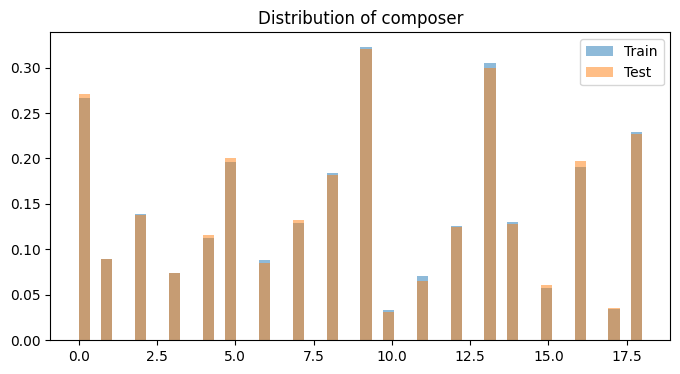

Feature: composer
Train stats:
count    70000.000000
mean         8.947443
std          5.561778
min          0.000000
25%          5.000000
50%          9.000000
75%         13.000000
max         18.000000
Name: composer, dtype: float64
Test stats:
count    69524.000000
mean         8.923724
std          5.581838
min          0.000000
25%          5.000000
50%          9.000000
75%         13.000000
max         18.000000
Name: composer, dtype: float64
----------------------------------------


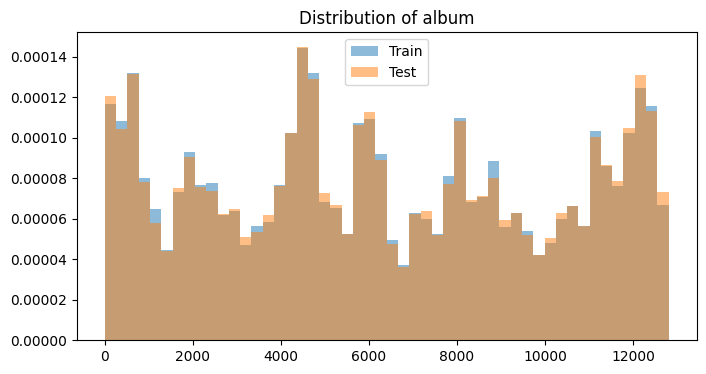

Feature: album
Train stats:
count    70000.000000
mean      6296.756657
std       3844.204745
min          0.000000
25%       2980.000000
50%       6039.000000
75%       9600.000000
max      12805.000000
Name: album, dtype: float64
Test stats:
count    69524.000000
mean      6329.969593
std       3851.759780
min          0.000000
25%       3066.000000
50%       6047.000000
75%       9679.000000
max      12805.000000
Name: album, dtype: float64
----------------------------------------


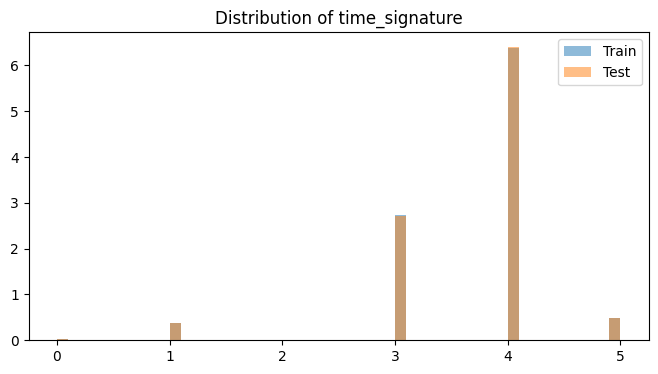

Feature: time_signature
Train stats:
count    70000.000000
mean         3.656857
std          0.756819
min          0.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: time_signature, dtype: float64
Test stats:
count    69524.000000
mean         3.656032
std          0.757838
min          0.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: time_signature, dtype: float64
----------------------------------------


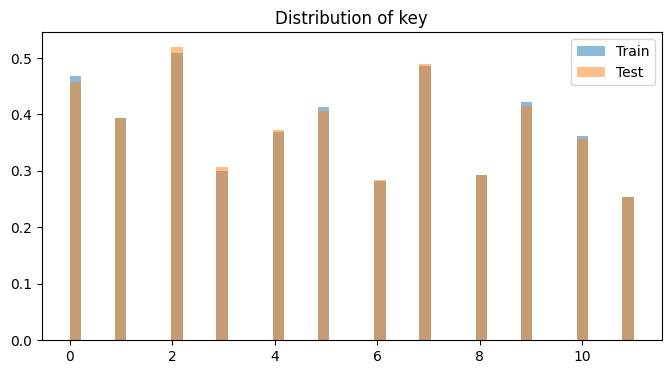

Feature: key
Train stats:
count    70000.000000
mean         5.162014
std          3.439068
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max         11.000000
Name: key, dtype: float64
Test stats:
count    69524.000000
mean         5.154421
std          3.428782
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max         11.000000
Name: key, dtype: float64
----------------------------------------


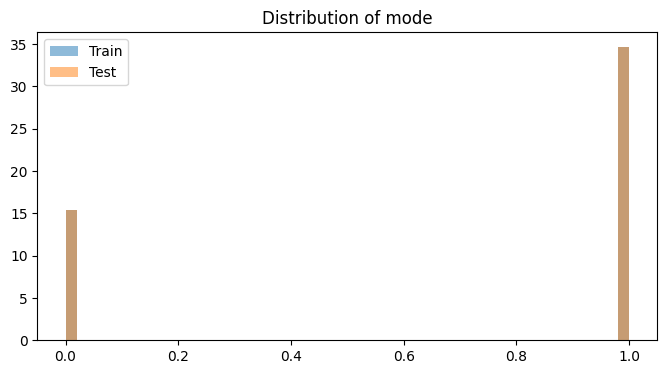

Feature: mode
Train stats:
count    70000.000000
mean         0.693214
std          0.461163
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: mode, dtype: float64
Test stats:
count    69524.000000
mean         0.692969
std          0.461266
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: mode, dtype: float64
----------------------------------------


In [174]:
numerical_features = ["danceability", "energy", "loudness",
                      "speechiness", "mode", "acousticness", "instrumentalness",
                      "liveness", "tempo", "duration_ms", "time_signature"]
cat_features = ["composer", "album", "time_signature", "key", "mode"]

for feature in cat_features:
    plt.figure(figsize=(8,4))
    plt.hist(train[feature], bins=50, alpha=0.5, label='Train', density=True)
    plt.hist(X_test[feature], bins=50, alpha=0.5, label='Test', density=True)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

    print(f"Feature: {feature}")
    print("Train stats:")
    print(train[feature].describe())
    print("Test stats:")
    print(X_test[feature].describe())
    print("-"*40)

Данные train и test имеют схожее распределение признаков  


In [175]:
for feature in cat_features:
    train_values = set(train[feature].unique())
    test_values = set(X_test[feature].unique())
    new_in_test = test_values - train_values
    print(f"Feature: {feature}")
    print(f"Unique in train: {len(train_values)}")
    print(f"Unique in test: {len(test_values)}")
    print(f"New categories in test not in train: {new_in_test}")
    print("-"*40)

Feature: composer
Unique in train: 19
Unique in test: 19
New categories in test not in train: set()
----------------------------------------
Feature: album
Unique in train: 11837
Unique in test: 11850
New categories in test not in train: {12288, 10244, 8197, 6, 8205, 10253, 2063, 12311, 2072, 8222, 6183, 10279, 2089, 2097, 51, 10291, 10293, 2104, 60, 2109, 4158, 12349, 10304, 4162, 2116, 4164, 71, 2119, 4168, 6215, 2123, 8268, 8269, 10316, 12366, 8279, 4185, 10330, 6238, 10334, 8289, 2152, 2154, 4204, 8301, 2169, 10361, 6268, 6271, 2176, 12425, 143, 144, 145, 146, 4243, 6287, 149, 6288, 10383, 10398, 161, 162, 10403, 10406, 8363, 10419, 12471, 10424, 185, 10428, 12478, 6342, 2248, 6344, 6346, 8397, 12496, 6353, 6360, 6369, 6372, 8421, 6375, 12531, 10488, 6393, 6394, 4347, 6406, 265, 2315, 10514, 2323, 276, 12565, 10518, 12568, 10521, 10523, 12572, 8480, 2341, 294, 8485, 8487, 8489, 8490, 10533, 12583, 6445, 12597, 6454, 314, 2364, 6465, 6466, 8513, 8515, 326, 10567, 328, 8520, 12621, 2

Для composer, time_signature, key, mode:  
Все test категории уже есть

Для album:  
Есть новые

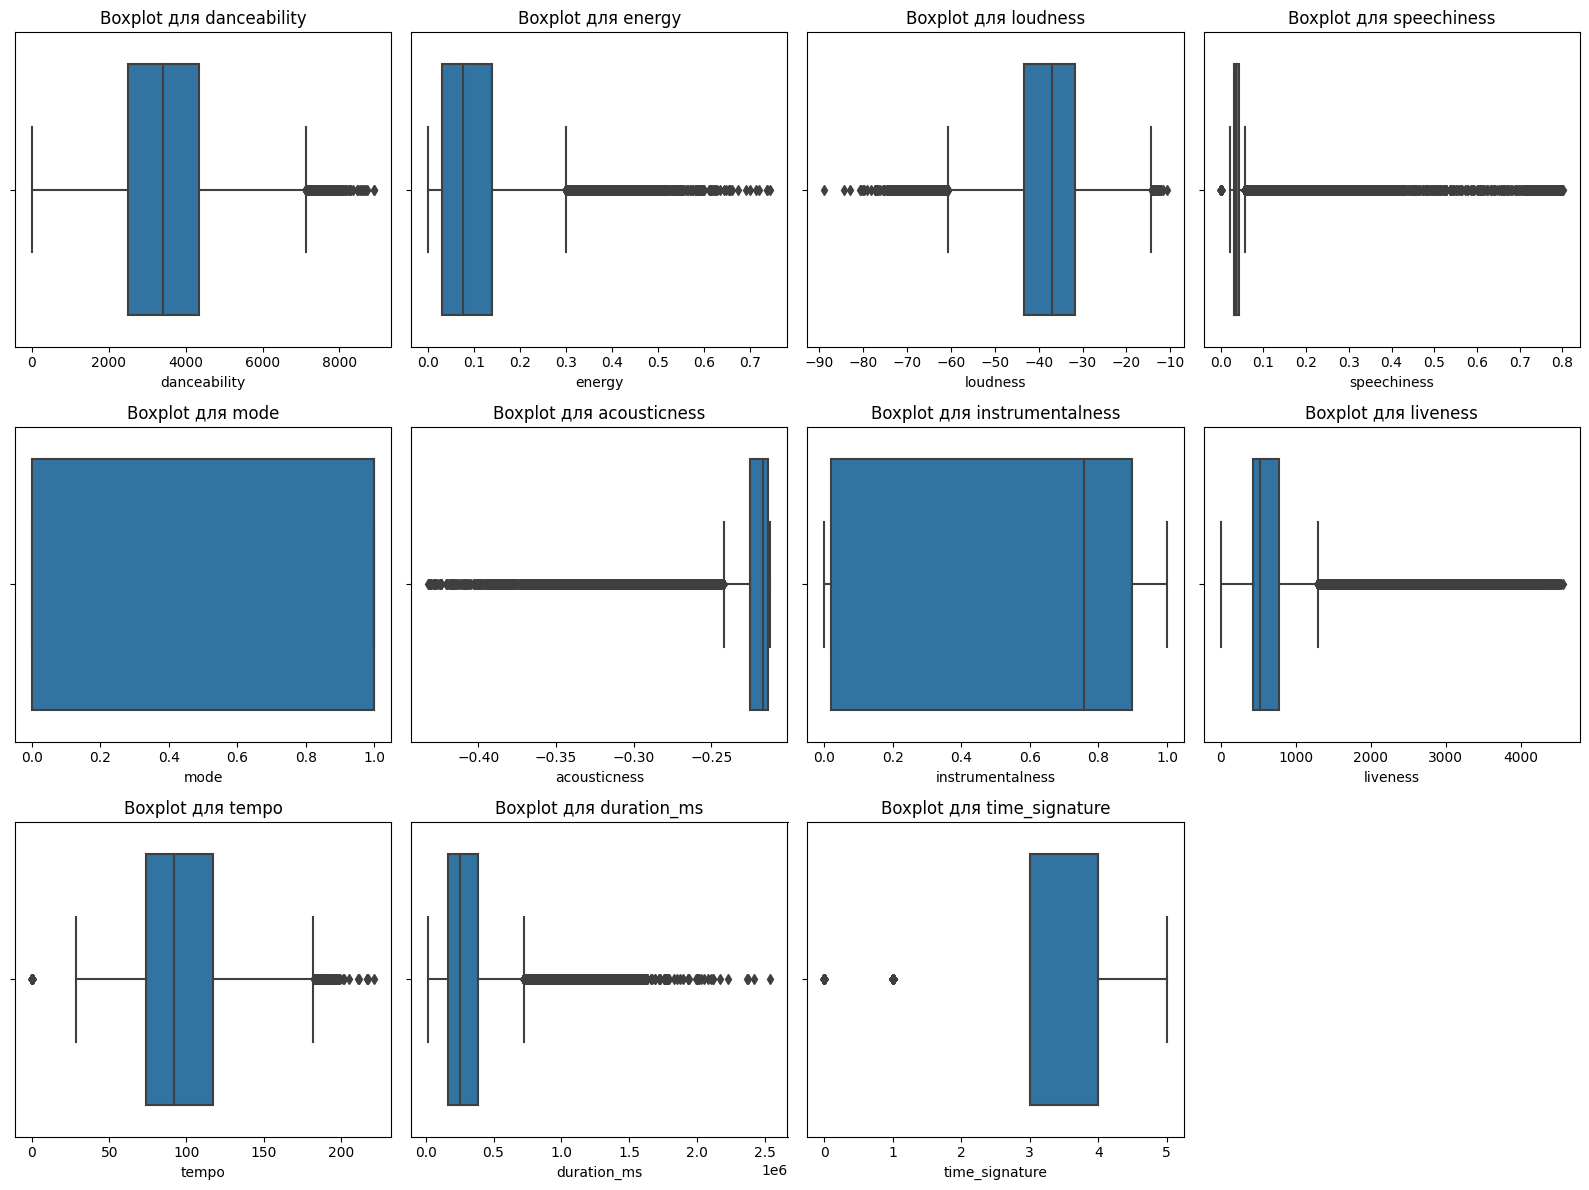

In [176]:
n_features = len(numerical_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x=train[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot для {feature}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Много выбросов практически у всех признаков  
Для многих признаков медиана смещена  
Необходимо прологарифмировать признаки с длинными хвостами  
Признаки с большим числом уникальных значений и выбросами можно попробовать разбить на квантили и использовать как категориальные признаки
Рассмотреть биннинговые признаки  
Попробовать IQR-тримминг

invalid value encountered in less


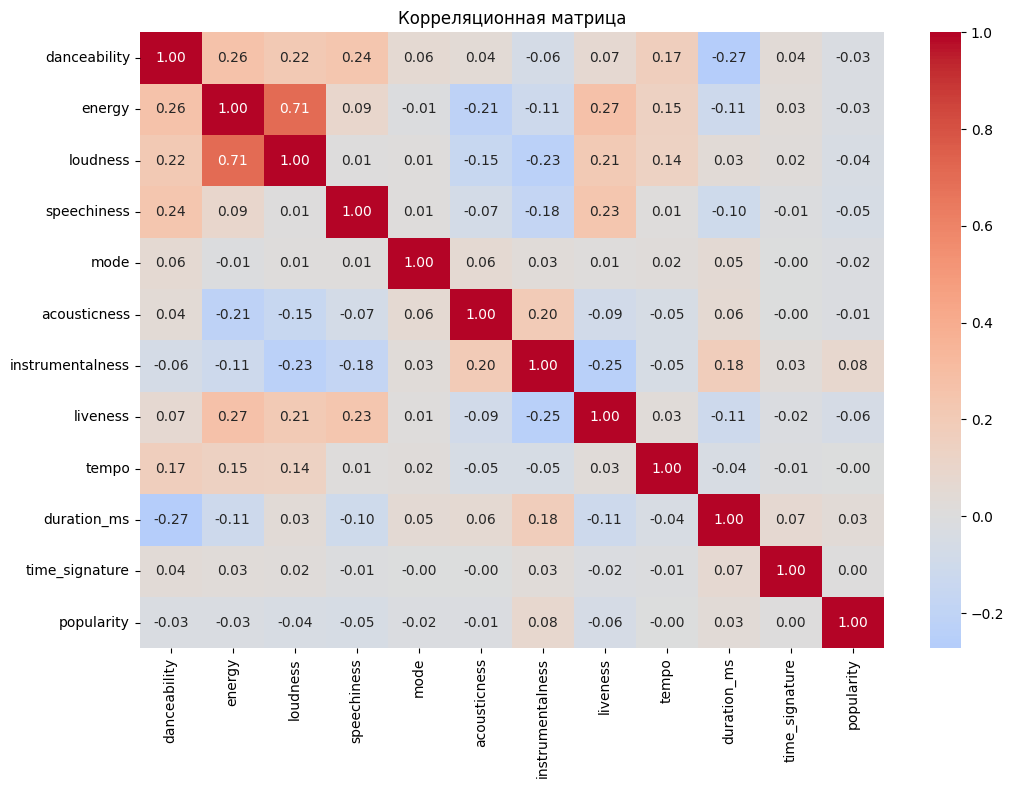

In [177]:
num_cols = numerical_features + ['popularity']

corr_matrix = train[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.show()

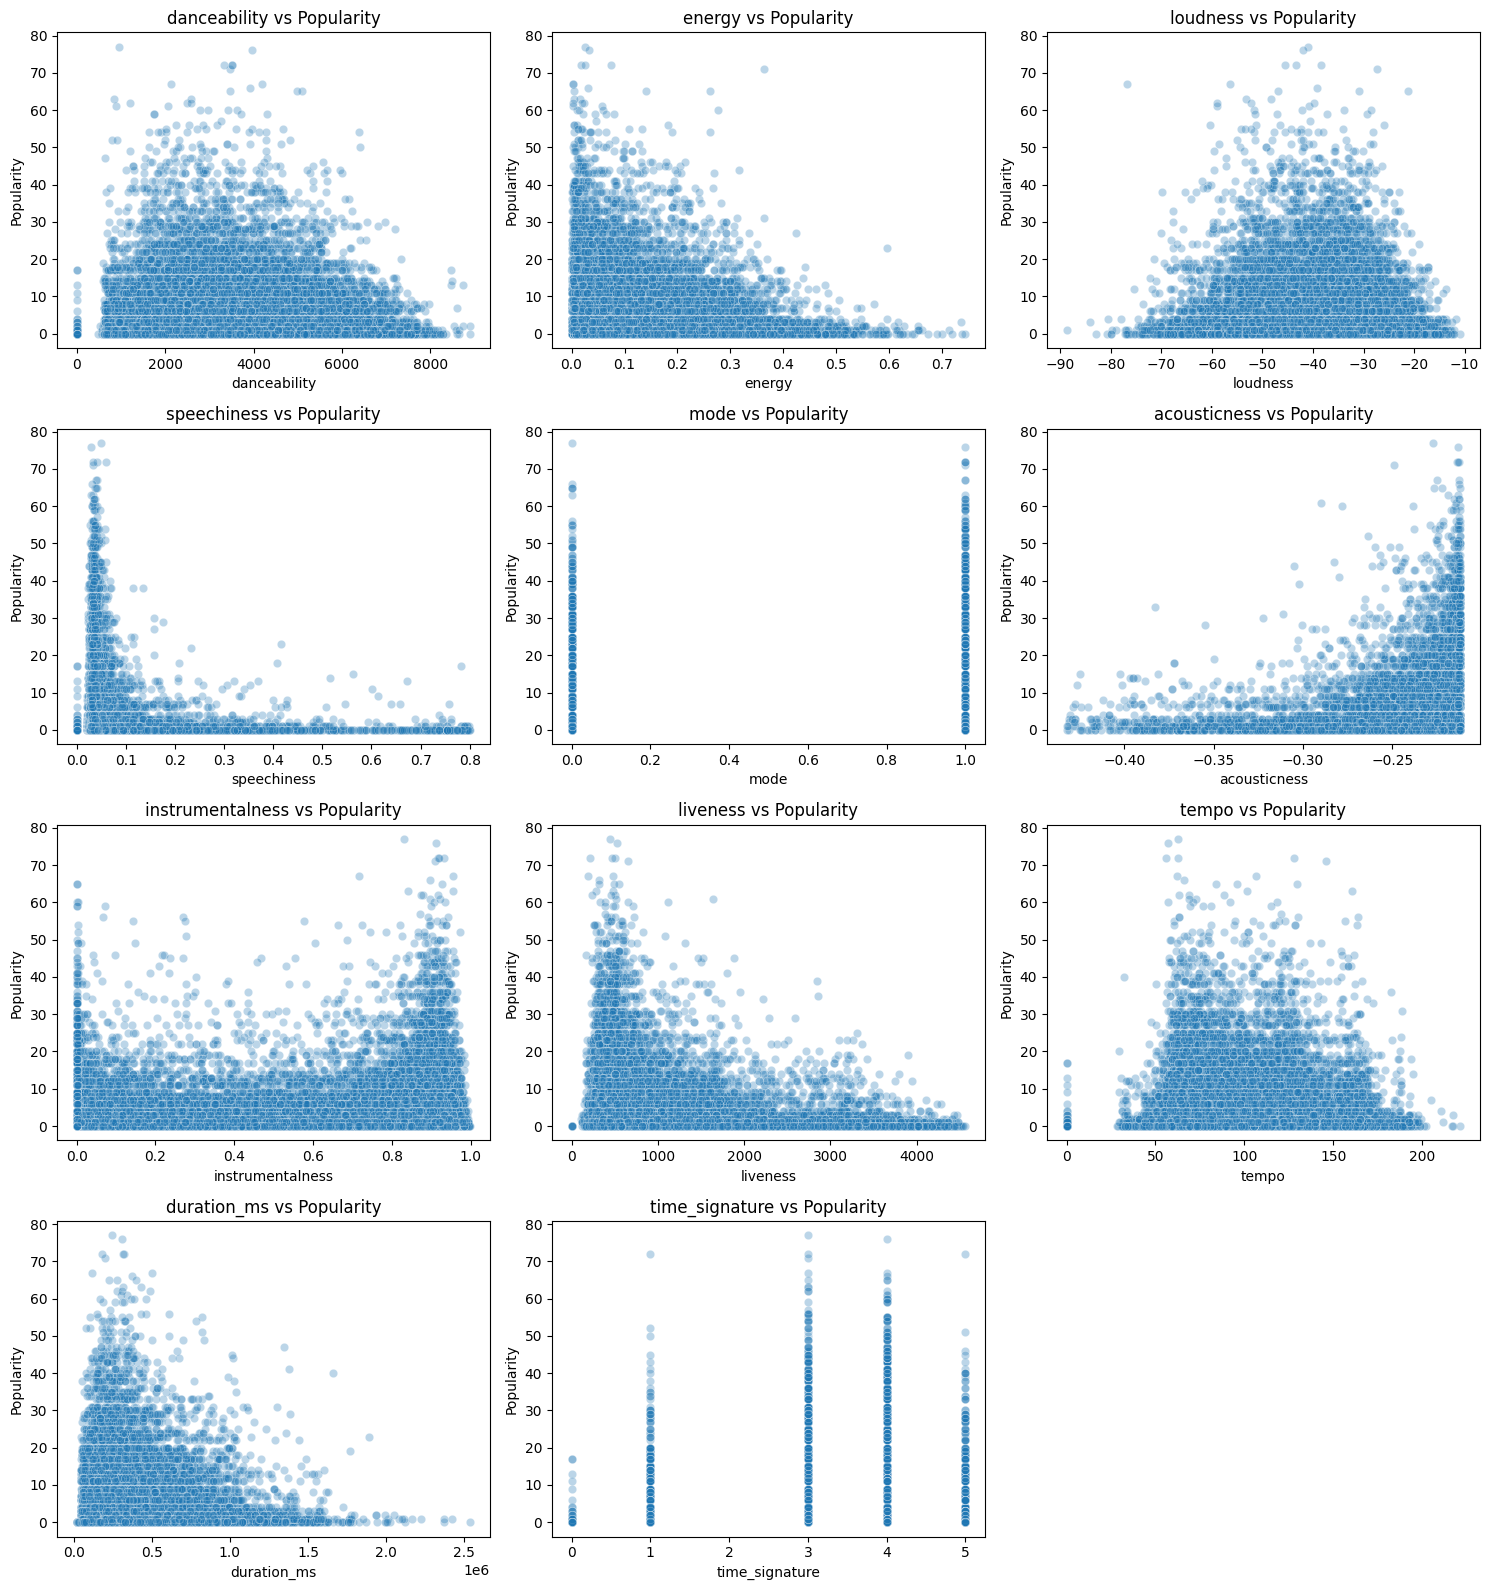

In [178]:
n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.scatterplot(x=X_train[feature], y=y_train, alpha=0.3, ax=axes[i])
    axes[i].set_title(f'{feature} vs Popularity')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Popularity')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Большинство числовых признаков имеют сложные, преимущественно нелинейные зависимости с целевой переменной  
Возможно, поможет добавление полиномиальных признаков  

# Cross-validation  

Необходим достаточно устойчивый способ сравнивать модели между собой  

In [179]:
# def create_bins(y, n_bins):
#     return pd.qcut(y, q=n_bins, labels=False, duplicates='drop')

# def run_cv(X, y, n_bins, n_splits, random_state=42):
#     y_binned = create_bins(y, n_bins)
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#     rmse_scores = []
#     best_iters = []

#     cat_features = ["composer", "album", "time_signature", "key", "mode"]

#     for train_idx, val_idx in skf.split(X, y_binned):
#         X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

#         model = CatBoostRegressor(
#             iterations=1000,
#             depth=6,
#             learning_rate=0.05,
#             early_stopping_rounds=50,
#             cat_features=cat_features,
#             random_seed=random_state,
#             verbose=False
#         )

#         model.fit(X_tr, y_tr, eval_set=(X_val, y_val), use_best_model=True)

#         preds = model.predict(X_val)
#         rmse = np.sqrt(mean_squared_error(y_val, preds))
#         rmse_scores.append(rmse)
#         best_iters.append(model.get_best_iteration())

#     return {
#         'mean_rmse': np.mean(rmse_scores),
#         'std_rmse': np.std(rmse_scores),
#         'min_rmse': np.min(rmse_scores),
#         'max_rmse': np.max(rmse_scores),
#         'mean_best_iter': np.mean(best_iters),
#         'std_best_iter': np.std(best_iters),
#         'rmse_scores': rmse_scores,
#         'best_iters': best_iters
#     }

In [180]:
# bins_list = [3, 5, 7, 10]
# splits_list = [3, 5, 7, 10]
# results = []

# for n_bins in bins_list:
#     for n_splits in splits_list:
#         print(f"CV: bins={n_bins}, splits={n_splits}")
#         stats = run_cv(X_train, y_train, n_bins=n_bins, n_splits=n_splits)
#         results.append({
#             'n_bins': n_bins,
#             'n_splits': n_splits,
#             'mean_rmse': stats['mean_rmse'],
#             'std_rmse': stats['std_rmse'],
#             'min_rmse': stats['min_rmse'],
#             'max_rmse': stats['max_rmse'],
#             'mean_best_iter': stats['mean_best_iter'],
#             'std_best_iter': stats['std_best_iter']
#         })

# df_results = pd.DataFrame(results)
# df_results.to_csv("cv_scheme_selection_results.csv", index=False)

In [181]:
# def repeated_cv(X, y, n_bins, n_splits, n_repeats=5):
#     rmse_all = []
#     best_iter_all = []
#     for seed in range(n_repeats):
#         stats = run_cv(X, y, n_bins=n_bins, n_splits=n_splits, random_state=seed)
#         rmse_all.extend(stats['rmse_scores'])
#         best_iter_all.extend(stats['best_iters'])
#     return {
#         'mean_rmse': np.mean(rmse_all),
#         'std_rmse': np.std(rmse_all),
#         'min_rmse': np.min(rmse_all),
#         'max_rmse': np.max(rmse_all),
#         'mean_best_iter': np.mean(best_iter_all),
#         'std_best_iter': np.std(best_iter_all),
#         'all_rmse': rmse_all,
#         'all_best_iter': best_iter_all
#     }

In [182]:
# schemes = [
#     {'n_bins': 7, 'n_splits': 7},
#     {'n_bins': 5, 'n_splits': 5},
#     {'n_bins': 3, 'n_splits': 3}
# ]

# clarification_results = []

# n_repeats = 5

# for scheme in schemes:
#     print(f"CV: bins={scheme['n_bins']}, splits={scheme['n_splits']}")
#     stats = repeated_cv(X_train, y_train, scheme['n_bins'], scheme['n_splits'], n_repeats=n_repeats)
#     clarification_results.append({
#         'n_bins': scheme['n_bins'],
#         'n_splits': scheme['n_splits'],
#         'mean_rmse': stats['mean_rmse'],
#         'std_rmse': stats['std_rmse'],
#         'min_rmse': stats['min_rmse'],
#         'max_rmse': stats['max_rmse'],
#         'mean_best_iter': stats['mean_best_iter'],
#         'std_best_iter': stats['std_best_iter']
#     })

# df_clarification = pd.DataFrame(clarification_results)
# df_clarification.to_csv("cv_scheme_selection_results_clarification.csv", index=False)

На основе результатов выберем самую стабильную схему с bins=5, splits=5

In [183]:
# def cross_validate_catboost(model, X, y, cat_features, n_splits=5, stratify_bins=5, random_state=42):
#     y_binned = pd.qcut(y, q=stratify_bins, labels=False, duplicates='drop')
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#     rmse_scores = []

#     for train_idx, val_idx in skf.split(X, y_binned):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#         model.fit(
#             X_train, y_train,
#             cat_features=cat_features,
#             eval_set=(X_val, y_val),
#             early_stopping_rounds=50,
#             use_best_model=True,
#             verbose=False
#         )

#         preds = model.predict(X_val)

#         rmse = mean_squared_error(y_val, preds, squared=False)
#         rmse_scores.append(rmse)

#     return {
#         'mean_rmse': np.mean(rmse_scores),
#         'std_rmse': np.std(rmse_scores),
#         'rmse_scores': rmse_scores
#     }

# Baseline

За безлайн возьмем одну из самых сильных моделей с достаточно стандартными параметрами

In [184]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]

In [185]:
# model = CatBoostRegressor(
#     iterations=1000,
#     depth=6,
#     learning_rate=0.05,
#     random_seed=42,
#     verbose=False
# )

# cv_results = cross_validate_catboost(model, X_train, y_train, cat_features)

# print(f"RMSE: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

# Features

Попробуем добавить простейшие признаки

In [186]:
# group = ['album']

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median'])
# agg_df.columns = [f'album_{col}_{agg}' for col, agg in agg_df.columns]
# agg_df = agg_df.reset_index()

# X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов по album: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [187]:
# groups = [['album'], ['composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# for group in groups:
#     group_name = '_'.join(group)
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов по album и composer: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [188]:
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# for group in groups:
#     group_name = '_'.join(group)
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов по album, composer и album+composer: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [189]:
# groups = [['album'], ['composer'], ['album', 'composer']]
# outlier_features = ['duration_ms', 'loudness', 'liveness', 'tempo']

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# for feature in outlier_features:
#     Q1 = X_all[feature].quantile(0.25)
#     Q3 = X_all[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     X_all[f'{feature}_outlier'] = ((X_all[feature] < lower_bound) | (X_all[feature] > upper_bound)).astype(int)

# cat_features = cat_features + [f'{feature}_outlier' for feature in outlier_features]

# for group in groups:
#     group_name = '_'.join(group)
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features=cat_features)

# print(f"RMSE после добавления агрегатов и бинарных признаков выбросов: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [190]:
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for group in groups:
#     group_name = '_'.join(group)
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов и замены выбросов на границы квантилей: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [191]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in numerical_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

# for group in groups:
#     group_name = '_'.join(group)
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов, замены выбросов и логарифмированных признаков: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [192]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in numerical_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

# for group in groups:
#     group_name = '_'.join(group)
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median', 'min', 'max'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов (mean, std, median + min, max), замены выбросов и логарифмированных признаков: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [193]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in numerical_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

# for group in groups:
#     group_name = '_'.join(group)
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
    
#     count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
#     agg_df = agg_df.merge(count_df, on=group, how='left')
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов (mean, std, median + min, max + sum, count), замены выбросов и логарифмированных признаков: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [194]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in numerical_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

# for group in groups:
#     group_name = '_'.join(group)
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
    
#     count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
#     agg_df = agg_df.merge(count_df, on=group, how='left')
#     X_all = X_all.merge(agg_df, on=group, how='left')
    
#     for feature in numerical_features:
#         median_col = f'{group_name}_{feature}_median'
#         diff_col = f'{group_name}_{feature}_diff_median'
#         abs_diff_col = f'{group_name}_{feature}_abs_diff_median'
#         ratio_col = f'{group_name}_{feature}_ratio_median'
        
#         X_all[diff_col] = X_all[feature] - X_all[median_col]
#         X_all[abs_diff_col] = X_all[diff_col].abs()
#         X_all[ratio_col] = X_all[feature] / (X_all[median_col] + 1e-5)

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [195]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in numerical_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

# for group in groups:
#     group_name = '_'.join(group)
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
    
#     count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
#     agg_df = agg_df.merge(count_df, on=group, how='left')
#     X_all = X_all.merge(agg_df, on=group, how='left')
    
#     for feature in numerical_features:
#         rank_col = f'{group_name}_{feature}_rank'
#         X_all[rank_col] = X_all.groupby(group)[feature].rank(pct=True)

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов и рангов: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [196]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in numerical_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

# def mad(series):
#     median = series.median()
#     return np.median(np.abs(series - median))

# for group in groups:
#     group_name = '_'.join(group)
    
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
    
#     mad_df = X_all.groupby(group)[numerical_features].agg(mad)
#     mad_df.columns = [f'{group_name}_{col}_mad' for col in mad_df.columns]
#     mad_df = mad_df.reset_index()
    
#     count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
    
#     agg_df = agg_df.merge(mad_df, on=group, how='left')
#     agg_df = agg_df.merge(count_df, on=group, how='left')
    
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов (mean, std, median, min, max, sum, mad, count), замены выбросов и логарифмированных признаков: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [197]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in numerical_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

# def mad(series):
#     median = series.median()
#     return np.median(np.abs(series - median))

# for group in groups:
#     group_name = '_'.join(group)
    
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
    
#     mad_df = X_all.groupby(group)[numerical_features].agg(mad)
#     mad_df.columns = [f'{group_name}_{col}_mad' for col in mad_df.columns]
#     mad_df = mad_df.reset_index()
    
#     count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
    
#     agg_df = agg_df.merge(mad_df, on=group, how='left')
#     agg_df = agg_df.merge(count_df, on=group, how='left')
    
#     X_all = X_all.merge(agg_df, on=group, how='left')
    
#     for feature in numerical_features:
#         min_col = f'{group_name}_{feature}_min'
#         max_col = f'{group_name}_{feature}_max'
#         dist_min_col = f'{group_name}_{feature}_dist_min'
#         dist_max_col = f'{group_name}_{feature}_dist_max'
        
#         X_all[dist_min_col] = X_all[feature] - X_all[min_col]
#         X_all[dist_max_col] = X_all[max_col] - X_all[feature]

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов (mean, std, median, min, max, sum, mad, count, dist_min, dist_max), замены выбросов и логарифмированных признаков: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [198]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in numerical_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

# def mad(series):
#     median = series.median()
#     return np.median(np.abs(series - median))

# for group in groups:
#     group_name = '_'.join(group)
    
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
    
#     mad_df = X_all.groupby(group)[numerical_features].agg(mad)
#     mad_df.columns = [f'{group_name}_{col}_mad' for col in mad_df.columns]
#     mad_df = mad_df.reset_index()
    
#     quantiles = X_all.groupby(group)[numerical_features].quantile([0.25, 0.75]).unstack(level=-1)
#     quantiles.columns = [f'{group_name}_{col}_q{int(q*100)}' for col, q in quantiles.columns]
#     quantiles = quantiles.reset_index()
    
#     for feature in numerical_features:
#         q25 = f'{group_name}_{feature}_q25'
#         q75 = f'{group_name}_{feature}_q75'
#         quantiles[f'{group_name}_{feature}_iqr'] = quantiles[q75] - quantiles[q25]
    
#     count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
    
#     agg_df = agg_df.merge(mad_df, on=group, how='left')
#     agg_df = agg_df.merge(quantiles, on=group, how='left')
#     agg_df = agg_df.merge(count_df, on=group, how='left')
    
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов (mean, std, median, min, max, sum, mad, q25, q75, iqr, count), замены выбросов и логарифмированных признаков: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [199]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
# base_numerical_features = numerical_features.copy()
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in numerical_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

# sq_features = {f'{feature}_sq': X_all[feature] ** 2 for feature in numerical_features}
# sq_df = pd.DataFrame(sq_features)

# interaction_features = {}
# for i, f1 in enumerate(base_numerical_features):
#     for f2 in base_numerical_features[i+1:]:
#         interaction_features[f'{f1}_x_{f2}'] = X_all[f1] * X_all[f2]
# interaction_df = pd.DataFrame(interaction_features)

# division_features = {}
# for i, f1 in enumerate(base_numerical_features):
#     for f2 in base_numerical_features[i+1:]:
#         denom = X_all[f2].replace(0, 1e-5)
#         division_features[f'{f1}_div_{f2}'] = X_all[f1] / denom
# division_df = pd.DataFrame(division_features)

# X_all = pd.concat([X_all, sq_df, interaction_df, division_df], axis=1)

# poly_features = list(sq_features.keys()) + list(interaction_features.keys()) + list(division_features.keys())
# numerical_features += poly_features

# def mad(series):
#     median = series.median()
#     return np.median(np.abs(series - median))

# for group in groups:
#     group_name = '_'.join(group)
    
#     agg_df = X_all.groupby(group)[base_numerical_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
    
#     mad_df = X_all.groupby(group)[base_numerical_features].agg(mad)
#     mad_df.columns = [f'{group_name}_{col}_mad' for col in mad_df.columns]
#     mad_df = mad_df.reset_index()
    
#     quantiles = X_all.groupby(group)[base_numerical_features].quantile([0.25, 0.75]).unstack(level=-1)
#     quantiles.columns = [f'{group_name}_{col}_q{int(q*100)}' for col, q in quantiles.columns]
#     quantiles = quantiles.reset_index()
    
#     for feature in base_numerical_features:
#         q25 = f'{group_name}_{feature}_q25'
#         q75 = f'{group_name}_{feature}_q75'
#         quantiles[f'{group_name}_{feature}_iqr'] = quantiles[q75] - quantiles[q25]
    
#     count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
    
#     agg_df = agg_df.merge(mad_df, on=group, how='left')
#     agg_df = agg_df.merge(quantiles, on=group, how='left')
#     agg_df = agg_df.merge(count_df, on=group, how='left')
    
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления полиномиальных признаков: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

Попробуем добавить признаки, отражающие музыкальную логику и стилистику

In [200]:
# tempo_quantiles = X_train_agg['tempo'].quantile([0.33, 0.66]).values

# def categorize_tempo(t):
#     if t <= tempo_quantiles[0]:
#         return 'slow'
#     elif t <= tempo_quantiles[1]:
#         return 'medium'
#     else:
#         return 'fast'

# X_train_agg['tempo_category'] = X_train_agg['tempo'].apply(categorize_tempo)
# cat_features.append('tempo_category')

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления tempo_category: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [201]:
# valence_quantiles = X_train_agg['valence'].quantile([0.33, 0.66]).values

# def categorize_valence(v):
#     if v <= valence_quantiles[0]:
#         return 'low'
#     elif v <= valence_quantiles[1]:
#         return 'medium'
#     else:
#         return 'high'

# X_train_agg['valence_category'] = X_train_agg['valence'].apply(categorize_valence)
# cat_features.append('valence_category')

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления valence_category: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [202]:
# def categorize_instrumentalness(i):
#     return 'high' if i > 0.5 else 'low'

# X_train_agg['instrumentalness_category'] = X_train_agg['instrumentalness'].apply(categorize_instrumentalness)
# cat_features.append('instrumentalness_category')

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления instrumentalness_category: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

Не помогло: добавление этих признаков ухудшило качество

Возьмем модель с наилучшим качеством с предыдущего шага и посмотрим на важности признаков, чтобы в дальнейшем это учитывать

In [203]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in numerical_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

# def mad(series):
#     median = series.median()
#     return np.median(np.abs(series - median))

# for group in groups:
#     group_name = '_'.join(group)
    
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
    
#     mad_df = X_all.groupby(group)[numerical_features].agg(mad)
#     mad_df.columns = [f'{group_name}_{col}_mad' for col in mad_df.columns]
#     mad_df = mad_df.reset_index()
    
#     quantiles = X_all.groupby(group)[numerical_features].quantile([0.25, 0.75]).unstack(level=-1)
#     quantiles.columns = [f'{group_name}_{col}_q{int(q*100)}' for col, q in quantiles.columns]
#     quantiles = quantiles.reset_index()
    
#     for feature in numerical_features:
#         q25 = f'{group_name}_{feature}_q25'
#         q75 = f'{group_name}_{feature}_q75'
#         quantiles[f'{group_name}_{feature}_iqr'] = quantiles[q75] - quantiles[q25]
    
#     count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
    
#     agg_df = agg_df.merge(mad_df, on=group, how='left')
#     agg_df = agg_df.merge(quantiles, on=group, how='left')
#     agg_df = agg_df.merge(count_df, on=group, how='left')
    
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE после добавления агрегатов (mean, std, median, min, max, sum, mad, q25, q75, iqr, count), замены выбросов и логарифмированных признаков: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [204]:
# sample = X_train_agg.sample(5000, random_state=42)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(sample)

# mean_abs_shap = np.abs(shap_values).mean(axis=0)
# top_indices = np.argsort(mean_abs_shap)[-30:]
# top_features = sample.columns[top_indices]

# shap.summary_plot(shap_values[:, top_indices], sample[top_features], max_display=30)

Принадлежность трека к определённому альбому или композитору сильно влияет на предсказанную популярность  
Агрегированные признаки по альбому и композитору также входят в топ  
Некоторые индивидуальные признаки тоже оказывают влияние, но уступают по значимости групповым  
Трансформация признаков была оправдана  

Признаки особо отбирать не стала из-за нехватки времени и потому, что CatBoost эффективно работает с большим количеством признаков и сам способен выявлять наиболее важные из них во время обучения

# Optimization

In [205]:
# cat_features = ["composer", "album", "time_signature", "key", "mode"]
# numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                       "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in numerical_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in numerical_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

# def mad(series):
#     median = series.median()
#     return np.median(np.abs(series - median))

# for group in groups:
#     group_name = '_'.join(group)
    
#     agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
    
#     mad_df = X_all.groupby(group)[numerical_features].agg(mad)
#     mad_df.columns = [f'{group_name}_{col}_mad' for col in mad_df.columns]
#     mad_df = mad_df.reset_index()
    
#     quantiles = X_all.groupby(group)[numerical_features].quantile([0.25, 0.75]).unstack(level=-1)
#     quantiles.columns = [f'{group_name}_{col}_q{int(q*100)}' for col, q in quantiles.columns]
#     quantiles = quantiles.reset_index()
    
#     for feature in numerical_features:
#         q25 = f'{group_name}_{feature}_q25'
#         q75 = f'{group_name}_{feature}_q75'
#         quantiles[f'{group_name}_{feature}_iqr'] = quantiles[q75] - quantiles[q25]
    
#     count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
    
#     agg_df = agg_df.merge(mad_df, on=group, how='left')
#     agg_df = agg_df.merge(quantiles, on=group, how='left')
#     agg_df = agg_df.merge(count_df, on=group, how='left')
    
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()
# X_test_agg = X_all.iloc[len(X_train):].copy()

In [206]:
# X_train_agg.head()

,composer,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,album_composer_log_energy_iqr,album_composer_log_loudness_iqr,album_composer_log_speechiness_iqr,album_composer_log_acousticness_iqr,album_composer_log_valence_iqr,album_composer_log_instrumentalness_iqr,album_composer_log_liveness_iqr,album_composer_log_tempo_iqr,album_composer_log_duration_ms_iqr,album_composer_count
0,14,1412,2967.280,0.045235,1,-38.440550,1,0.036275,-0.223432,0.706,...,0.024778,0.269974,0.002163,0.010056,0.071542,0.152592,0.474762,0.255375,0.346626,17
1,7,9772,5596.904,0.071796,9,-43.769375,1,0.050086,-0.212998,0.777,...,0.053739,0.359036,0.019229,0.001410,0.200737,0.034682,0.337965,0.270883,0.340496,43
2,16,10251,3345.864,0.109368,4,-42.194985,0,0.037856,-0.212332,0.925,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,16,9342,2486.376,0.056395,9,-33.632870,0,0.032282,-0.212554,0.906,...,0.028591,0.067195,0.002320,0.000988,0.028919,0.014403,0.267366,0.508532,0.224602,6
4,9,4646,6169.896,0.086304,2,-33.402815,1,0.034611,-0.235420,0.932,...,0.101418,0.176482,0.005810,0.018002,0.219816,0.040100,0.268063,0.294383,0.577038,20


In [207]:
# X_test_agg.head()

,composer,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,album_composer_log_energy_iqr,album_composer_log_loudness_iqr,album_composer_log_speechiness_iqr,album_composer_log_acousticness_iqr,album_composer_log_valence_iqr,album_composer_log_instrumentalness_iqr,album_composer_log_liveness_iqr,album_composer_log_tempo_iqr,album_composer_log_duration_ms_iqr,album_composer_count
70000,1,3217,2701.248,0.100440,4,-30.061540,0,0.030202,-0.242080,0.91900,...,0.045451,0.095591,0.002338,0.000000,0.097566,0.026531,0.483630,0.343695,0.132551,8
70001,11,8739,1995.240,0.096720,3,-32.346440,1,0.036858,-0.219880,0.00169,...,0.088616,0.260416,0.013775,0.017583,0.124011,0.014826,0.770062,0.277511,0.683886,60
70002,2,2548,4727.184,0.003586,1,-46.639585,0,0.041184,-0.211888,0.89100,...,0.021469,0.846512,0.010241,0.000282,0.046849,0.024386,0.265804,0.453568,0.538321,31
70003,1,3219,2445.448,0.122760,5,-27.883060,1,0.029370,-0.223432,0.91200,...,0.096364,0.293493,0.004582,0.007492,0.081572,0.041993,0.204583,0.269905,0.226855,14
70004,0,11933,4942.056,0.116064,9,-32.474770,0,0.033030,-0.214774,0.62400,...,0.099182,0.309320,0.005194,0.016676,0.373388,0.372386,0.581446,0.221562,0.186738,16


In [208]:
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 2500),
#         'depth': trial.suggest_int('depth', 4, 8),
#         'random_seed': 42,
#         'verbose': False
#     }
    
#     model = CatBoostRegressor(**params)
    
#     cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)
    
#     return cv_results['mean_rmse']

# max_jobs = os.cpu_count() 
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50, n_jobs=max_jobs)

# print("Лучшие параметры:", study.best_params)
# print(f"Лучшее среднее RMSE: {study.best_value:.4f}")

Хороший способ подбора гиперпараметров, но времени не хватило =(

Попробуем в лоб перебрать пару значений количества итераций, все остальные значения пускай останутся стандартными  
Также можно было попробовать XGBoost или LightGBM, но CatBoost показался наиболее универсальным  

In [209]:
# model = CatBoostRegressor(
#     iterations=1500,
#     depth=6,
#     learning_rate=0.05,
#     early_stopping_rounds=50,
#     random_seed=42,
#     verbose=False
# )

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [210]:
# model = CatBoostRegressor(
#     iterations=2000,
#     depth=6,
#     learning_rate=0.05,
#     early_stopping_rounds=50,
#     random_seed=42,
#     verbose=False
# )

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [211]:
# X_train_628 = X_train_agg.copy()
# X_test_628 = X_test_agg.copy()
# all_features_628 = X_train_628.columns.tolist()
# cat_features_628 = ["composer", "album", "time_signature", "key", "mode"]
# num_features_628 = [f for f in all_features_628 if f not in cat_features_628]

# print(len(all_features_628))
# print(len(num_features_628))
# print(len(X_train_628))
# print(len(X_test_628))

# data_to_save = {
#     'X_train_629': X_train_628,
#     'X_test_629': X_test_628,
#     'cat_features_629': cat_features_628,
#     'num_features_629': num_features_628
# }

# with open('catboost_628.pkl', 'wb') as f:
#     pickle.dump(data_to_save, f)

628
623
70000
69524


# Feature Selection

In [212]:
# model = CatBoostRegressor(
#     iterations=2000,
#     depth=6,
#     learning_rate=0.05,
#     early_stopping_rounds=50,
#     random_seed=42,
#     verbose=False
# )

# model.fit(
#     X_train_628, y_train,
#     cat_features=cat_features_628,
#     verbose=False
# )

In [213]:
# num_features = X_train_agg.shape[1]
# print(f"Количество признаков: {num_features}")

# feature_importances = model.get_feature_importance()
# feature_names = X_train_agg.columns

# fi_df = pd.DataFrame({
#     'feature': feature_names,
#     'importance': feature_importances
# }).sort_values(by='importance', ascending=False)

# fi_df = fi_df.reset_index(drop=True)
# fi_df.index = fi_df.index + 1

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# print(f"Наиболее важные в рамках catboost:")
# print(fi_df)

# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

Количество признаков: 628


In [214]:
# top_200_features = fi_df.head(200)['feature'].tolist()
# print(f"Выбрано {len(top_200_features)} признаков")

# X_train_top_200 = X_train_628[top_200_features].copy()
# X_test_top_200 = X_test_628[top_200_features].copy()

# cat_features_top_200 = [f for f in cat_features_628 if f in top_200_features]
# num_features_top_200 = [f for f in top_200_features if f not in cat_features_top_200]

# print(f"Категориальных признаков среди топ-200: {len(cat_features_top_200)}")
# print(f"Числовых признаков среди топ-200: {len(num_features_top_200)}")

# data_to_save_top_200 = {
#     'X_train': X_train_top_200,
#     'X_test': X_test_top_200,
#     'cat_features': cat_features_top_200,
#     'num_features': num_features_top_200
# }

# with open('catboost_top_200.pkl', 'wb') as f:
#     pickle.dump(data_to_save_top_200, f)

Выбрано 200 признаков
Категориальных признаков среди топ-200: 3
Числовых признаков среди топ-200: 197


# Catboost

In [ ]:
cat_features = ["composer", "album", "time_signature", "key", "mode"]
numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
                      "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
groups = [['album'], ['composer'], ['album', 'composer']]

X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

def trim_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
    df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
    return df

for feature in numerical_features:
    X_all = trim_outliers_iqr(X_all, feature)

for feature in numerical_features:
    min_val = X_all[feature].min()
    shift = 0
    if min_val <= -1:
        shift = abs(min_val) + 1e-5
    X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

numerical_features = numerical_features + [f'log_{f}' for f in numerical_features]

def mad(series):
    median = series.median()
    return np.median(np.abs(series - median))

for group in groups:
    group_name = '_'.join(group)
    
    agg_df = X_all.groupby(group)[numerical_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
    agg_df = agg_df.reset_index()
    
    mad_df = X_all.groupby(group)[numerical_features].agg(mad)
    mad_df.columns = [f'{group_name}_{col}_mad' for col in mad_df.columns]
    mad_df = mad_df.reset_index()
    
    quantiles = X_all.groupby(group)[numerical_features].quantile([0.25, 0.75]).unstack(level=-1)
    quantiles.columns = [f'{group_name}_{col}_q{int(q*100)}' for col, q in quantiles.columns]
    quantiles = quantiles.reset_index()
    
    for feature in numerical_features:
        q25 = f'{group_name}_{feature}_q25'
        q75 = f'{group_name}_{feature}_q75'
        quantiles[f'{group_name}_{feature}_iqr'] = quantiles[q75] - quantiles[q25]
    
    count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
    
    agg_df = agg_df.merge(mad_df, on=group, how='left')
    agg_df = agg_df.merge(quantiles, on=group, how='left')
    agg_df = agg_df.merge(count_df, on=group, how='left')
    
    X_all = X_all.merge(agg_df, on=group, how='left')

X_train_agg = X_all.iloc[:len(X_train)].copy()
X_test_agg = X_all.iloc[len(X_train):].copy()

In [ ]:
X_train_628 = X_train_agg.copy()
X_test_628 = X_test_agg.copy()
all_features_628 = X_train_628.columns.tolist()
cat_features_628 = ["composer", "album", "time_signature", "key", "mode"]
num_features_628 = [f for f in all_features_628 if f not in cat_features_628]

print(len(all_features_628))
print(len(num_features_628))
print(len(X_train_628))
print(len(X_test_628))

data_to_save = {
    'X_train_629': X_train_628,
    'X_test_629': X_test_628,
    'cat_features_629': cat_features_628,
    'num_features_629': num_features_628
}

with open('catboost_628.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [ ]:
model = CatBoostRegressor(
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=False
)

model.fit(
    X_train_628, y_train,
    cat_features=cat_features_628,
    verbose=False
)

In [ ]:
num_features = X_train_agg.shape[1]
print(f"Количество признаков: {num_features}")

feature_importances = model.get_feature_importance()
feature_names = X_train_agg.columns

fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

fi_df = fi_df.reset_index(drop=True)
fi_df.index = fi_df.index + 1

In [ ]:
top_200_features = fi_df.head(200)['feature'].tolist()
print(f"Выбрано {len(top_200_features)} признаков")

X_train_top_200 = X_train_628[top_200_features].copy()
X_test_top_200 = X_test_628[top_200_features].copy()

cat_features_top_200 = [f for f in cat_features_628 if f in top_200_features]
num_features_top_200 = [f for f in top_200_features if f not in cat_features_top_200]

print(f"Категориальных признаков среди топ-200: {len(cat_features_top_200)}")
print(f"Числовых признаков среди топ-200: {len(num_features_top_200)}")

data_to_save_top_200 = {
    'X_train': X_train_top_200,
    'X_test': X_test_top_200,
    'cat_features': cat_features_top_200,
    'num_features': num_features_top_200
}

with open('catboost_top_200.pkl', 'wb') as f:
    pickle.dump(data_to_save_top_200, f)

In [ ]:
# model = CatBoostRegressor(
#     iterations=2000,
#     depth=6,
#     learning_rate=0.05,
#     early_stopping_rounds=50,
#     random_seed=42,
#     verbose=False
# )

# model.fit(
#     X_train_top_200, y_train,
#     cat_features=cat_features_top_200,
#     verbose=False
# )

# Random forest

Для категориальных признаков применим таргетное кодирование

In [267]:
cat_features = ["composer", "album", "time_signature", "key", "mode"]
numerical_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
                      "valence", "instrumentalness", "liveness", "tempo", "duration_ms"]
groups = [['album'], ['composer'], ['album', 'composer']]

X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

def trim_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
    df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
    return df

for feature in numerical_features:
    X_all = trim_outliers_iqr(X_all, feature)

for feature in numerical_features:
    min_val = X_all[feature].min()
    shift = 0
    if min_val <= -1:
        shift = abs(min_val) + 1e-5
    X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

numerical_features_all = numerical_features + [f'log_{f}' for f in numerical_features]

for group in groups:
    group_name = '_'.join(group)
    
    agg_df = X_all.groupby(group)[numerical_features_all].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
    agg_df = agg_df.reset_index()
    
    count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
    agg_df = agg_df.merge(count_df, on=group, how='left')
    
    X_all = X_all.merge(agg_df, on=group, how='left')

X_train_agg = X_all.iloc[:len(X_train)].copy()
X_test_agg = X_all.iloc[len(X_train):].copy()

def target_encode_album_composer(train_df, target, test_df):
    train_tmp = train_df.copy()
    train_tmp['target'] = target.values

    agg_pair = train_tmp.groupby(['album', 'composer'])['target'].mean().reset_index()
    mapping_pair = agg_pair.set_index(['album', 'composer'])['target'].to_dict()

    agg_composer = train_tmp.groupby('composer')['target'].mean().reset_index()
    mapping_composer = agg_composer.set_index('composer')['target'].to_dict()

    global_mean = target.mean()

    def map_pair(row):
        key = (row['album'], row['composer'])
        if key in mapping_pair:
            return mapping_pair[key]
        elif row['composer'] in mapping_composer:
            return mapping_composer[row['composer']]
        else:
            return global_mean

    train_encoded = train_df.copy()
    train_encoded['album_composer_te'] = train_encoded.apply(map_pair, axis=1)

    test_encoded = test_df.copy()
    test_encoded['album_composer_te'] = test_encoded.apply(map_pair, axis=1)

    return train_encoded, test_encoded

X_train_agg_TE, X_test_agg_TE = target_encode_album_composer(X_train_agg, y_train, X_test_agg)

cat_features = [c for c in cat_features if c not in ['composer', 'album']]

X_train_agg_TE = X_train_agg_TE.drop(columns=['album', 'composer'])
X_test_agg_TE = X_test_agg_TE.drop(columns=['album', 'composer'])

def bin_target(y, n_bins=5):
    y_binned = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')
    return y_binned

def target_encode_cv_stratified(train_df, target, cat_cols, n_splits=5, n_bins=5):
    train_encoded = train_df.copy()
    global_mean = target.mean()
    
    y_binned = bin_target(target, n_bins)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for col in cat_cols:
        oof = pd.Series(index=train_df.index, dtype=float)
        
        for train_idx, val_idx in skf.split(train_df, y_binned):
            means = target.iloc[train_idx].groupby(train_df.iloc[train_idx][col]).mean()
            oof.iloc[val_idx] = train_df.iloc[val_idx][col].map(means)
        
        oof.fillna(global_mean, inplace=True)
        train_encoded[f'{col}_te'] = oof
        
    return train_encoded

def target_encode_test(train_series, target, test_series):
    global_mean = target.mean()
    means = target.groupby(train_series).mean()
    return test_series.map(means).fillna(global_mean)

other_cat_features = ['time_signature', 'key', 'mode']

X_train_agg_TE = target_encode_cv_stratified(X_train_agg_TE, y_train, other_cat_features, n_splits=5, n_bins=5)

X_test_agg_TE = X_test_agg_TE.copy()
for col in other_cat_features:
    X_test_agg_TE[f'{col}_te'] = target_encode_test(X_train_agg_TE[col], y_train, X_test_agg_TE[col])

X_train_agg_TE = X_train_agg_TE.drop(columns=other_cat_features)
X_test_agg_TE = X_test_agg_TE.drop(columns=other_cat_features)

X_train_agg_TE = X_train_agg_TE.fillna(0)
X_test_agg_TE = X_test_agg_TE.fillna(0)

In [268]:
X_train_RF_387 = X_train_agg_TE.copy()
X_test_RF_387 = X_test_agg_TE.copy()
num_features_RF_387 = X_train_agg_TE.columns.tolist()

print(len(X_train_RF_387))
print(len(X_test_RF_387))
print(len(num_features_RF_387))

data_to_save = {
    'X_train': X_train_RF_387,
    'X_test': X_test_RF_387,
    'num_features': num_features_RF_387
}

with open('random_forest_387.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

70000
69524
387


In [269]:
# rf_model = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=10,
#     random_state=42,
#     n_jobs=-1
# )

# rf_model.fit(X_train_RF_387, y_train)
# train_preds = rf_model.predict(X_train_RF_387)
# rmse_train = mean_squared_error(y_train, train_preds, squared=False)

# print(f"RMSE на train: {rmse_train:.4f}")

RMSE на train: 2.3674


# Stacking

In [ ]:
y_train_log = np.log1p(y_train)

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_preds_rf = np.zeros(len(X_train_RF_387))
oof_preds_cb = np.zeros(len(X_train_top_200))

test_preds_rf = np.zeros(len(X_test_RF_387))
test_preds_cb = np.zeros(len(X_test_top_200))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_RF_387)):
    print(f"Fold {fold+1}")

    X_tr_rf, X_val_rf = X_train_RF_387.iloc[train_idx], X_train_RF_387.iloc[val_idx]
    y_tr_log, y_val_log = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    rf_fold = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf_fold.fit(X_tr_rf, y_tr_log)
    oof_preds_rf[val_idx] = np.expm1(rf_fold.predict(X_val_rf))
    test_preds_rf += np.expm1(rf_fold.predict(X_test_RF_387)) / n_splits

    X_tr_cb, X_val_cb = X_train_top_200.iloc[train_idx], X_train_top_200.iloc[val_idx]

    cb_fold = CatBoostRegressor(
        iterations=2000,
        depth=6,
        learning_rate=0.05,
        early_stopping_rounds=50,
        random_seed=42,
        verbose=False
    )
    
    cb_fold.fit(
        X_tr_cb, y_tr_log,
        cat_features=cat_features_top_200,
        eval_set=(X_val_cb, y_val_log),
        use_best_model=True,
        verbose=False
    )
    
    oof_preds_cb[val_idx] = np.expm1(cb_fold.predict(X_val_cb))
    test_preds_cb += np.expm1(cb_fold.predict(X_test_top_200)) / n_splits

stacked_train = pd.DataFrame({'rf_pred': oof_preds_rf, 'cb_pred': oof_preds_cb})
stacked_test = pd.DataFrame({'rf_pred': test_preds_rf, 'cb_pred': test_preds_cb})

In [278]:
meta_model = LinearRegression()
meta_model.fit(stacked_train, y_train)

stacked_train_preds = meta_model.predict(stacked_train)
rmse_train = np.sqrt(mean_squared_error(y_train, stacked_train_preds))
print(f"RMSE стекинга на train: {rmse_train:.4f}")

RMSE стекинга на train: 2.9832


In [281]:
rf_full = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_full.fit(X_train_RF_387, y_train_log)

cb_full = CatBoostRegressor(
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=False
)

cb_full.fit(
    X_train_top_200, y_train_log,
    cat_features=cat_features_top_200,
    verbose=False
)

train_preds_rf_full = np.expm1(rf_full.predict(X_train_RF_387))
train_preds_cb_full = np.expm1(cb_full.predict(X_train_top_200))

stacked_train_full = pd.DataFrame({
    'rf_pred': train_preds_rf_full,
    'cb_pred': train_preds_cb_full
})

stacked_train_preds = meta_model.predict(stacked_train_full)
rmse_train = np.sqrt(mean_squared_error(y_train, stacked_train_preds))
print(f"RMSE стекинга на train: {rmse_train:.4f}")

RMSE стекинга на train: 2.7183


In [284]:
test_preds_rf_full = np.expm1(rf_full.predict(X_test_RF_387))
test_preds_cb_full = np.expm1(cb_full.predict(X_test_top_200))

stacked_test_full = pd.DataFrame({
    'rf_pred': test_preds_rf_full,
    'cb_pred': test_preds_cb_full
})

final_test_preds = meta_model.predict(stacked_test_full)

submission = pd.DataFrame({
    "index": test["index"],
    "popularity": final_test_preds
})

submission.to_csv("/kaggle/working/submission.csv", index=False)